In [13]:
import Pkg
Pkg.activate(".")
Pkg.add(["CairoMakie", "LinearAlgebra", "Convex", "SCS", "Statistics"])

using CairoMakie, LinearAlgebra, Statistics, Convex, SCS

  Activating project at `C:\Users\carsi\BME 574`
   Resolving package versions...
    Updating `C:\Users\carsi\BME 574\Project.toml`
⌃ [13f3f980] + CairoMakie v0.12.14
  [10745b16] + Statistics v1.10.0
    Updating `C:\Users\carsi\BME 574\Manifest.toml`
  [159f3aea] + Cairo v1.1.0
⌃ [13f3f980] + CairoMakie v0.12.14
  [a2bd30eb] + Graphics v1.1.2
        Info Packages marked with ⌃ have new versions available and may be upgradable.
Precompiling project...
  ✓ Cairo
  ✓ CairoMakie
  2 dependencies successfully precompiled in 88 seconds. 407 already precompiled.


In [14]:
# data generation and regression setup
const x_vals = LinRange(-2, 2, 100)
const y_true = x_vals.^2  # true function without noise

# polynomial design matrix up to the 19th degree
function create_design_matrix(x::AbstractVector, max_degree::Int)
    return reduce(hcat, [x .^ p for p in 0:max_degree])
end


create_design_matrix (generic function with 1 method)

In [15]:
# least squares regression
function fit_least_squares(A, y)
    return pinv(A) * y
end

# LASSO regression
function fit_lasso(A, y, lambda_1, lambda_2)
    coefficients = Variable(size(A)[2])
    problem = minimize(norm(A * coefficients - y, 2) + lambda_1 * norm(coefficients, 1) + lambda_2 * norm(coefficients, 2))
    solve!(problem, SCS.Optimizer; silent = true)
    return vec(evaluate(coefficients))
end


fit_lasso (generic function with 1 method)

In [16]:
# run trials to estimate coefficients and errors
function run_trials(A, y_true, n_trials, noise_level, lambda_1, lambda_2)
    coefficients_ls = zeros(20, n_trials)
    coefficients_lasso = zeros(20, n_trials)
    errors_ls = zeros(n_trials)
    errors_lasso = zeros(n_trials)

    for i in 1:n_trials
        y_noise = y_true .+ noise_level * randn(length(y_true)) # generate noisy data
        
        # Least Squares fit
        coefficients_ls[:, i] = fit_least_squares(A, y_noise)
        errors_ls[i] = norm(y_true - A * coefficients_ls[:, i])

        # LASSO fit
        coefficients_lasso[:, i] = fit_lasso(A, y_noise, lambda_1, lambda_2)
        errors_lasso[i] = norm(y_true - A * coefficients_lasso[:, i])
    end

    return coefficients_ls, coefficients_lasso, errors_ls, errors_lasso
end


run_trials (generic function with 2 methods)

In [21]:
# Plotting

# function for coefficients and error comparison
function plot_results(coefficients_ls, coefficients_lasso, errors_ls, errors_lasso)
    # coefficients distribution
    fig_coeffs = Figure(size=(900, 400))
    ax1 = Axis(fig_coeffs[1, 1], title="Least Squares Coefficients", xlabel="Polynomial Degree", ylabel="Variance", xticks=1:20)
    boxplot!(ax1, repeat(1:20, size(coefficients_ls, 2)), vec(coefficients_ls), color=:blue)

    ax2 = Axis(fig_coeffs[1, 2], title="LASSO Coefficients", xlabel="Polynomial Degree", ylabel="Variance", xticks=1:20)
    boxplot!(ax2, repeat(1:20, size(coefficients_lasso, 2)), vec(coefficients_lasso), color=:red)
    display(fig_coeffs)

    # error comparison
    combined_errors = vcat(errors_ls, errors_lasso)
    group_labels = repeat([1, 2], inner=length(errors_ls))
    fig_errors = Figure()
    ax_error = Axis(fig_errors[1, 1], title="Error Comparison", xlabel="Regression Method (1 = Least Squares, 2 = LASSO)", ylabel="Error")
    boxplot!(ax_error, group_labels, combined_errors, color=:purple)
    display(fig_errors)
end


plot_results (generic function with 1 method)

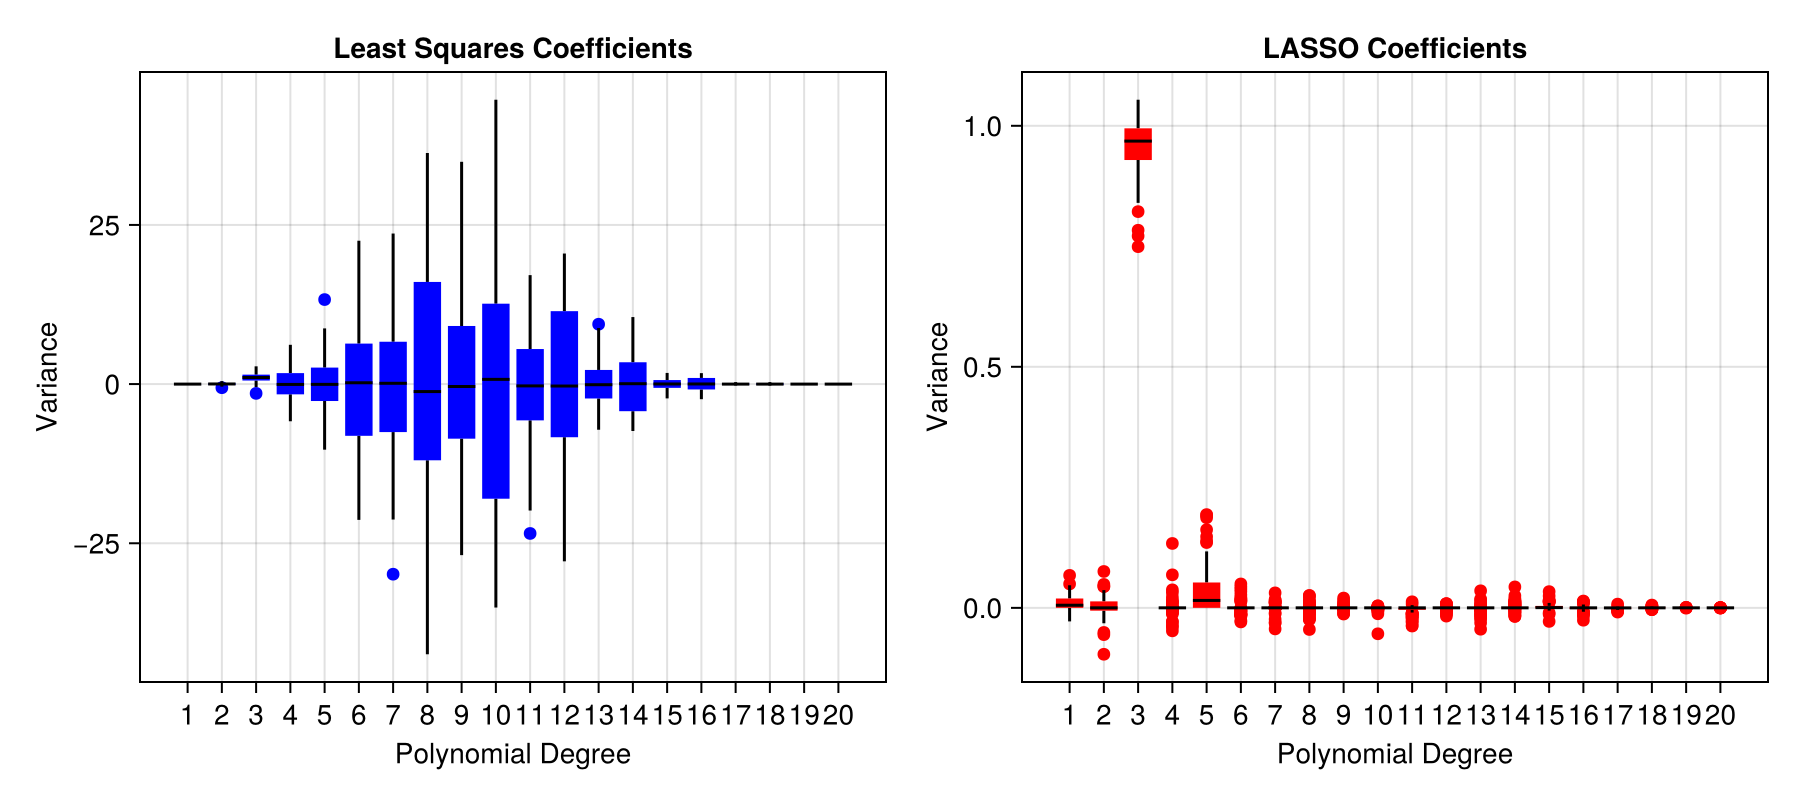

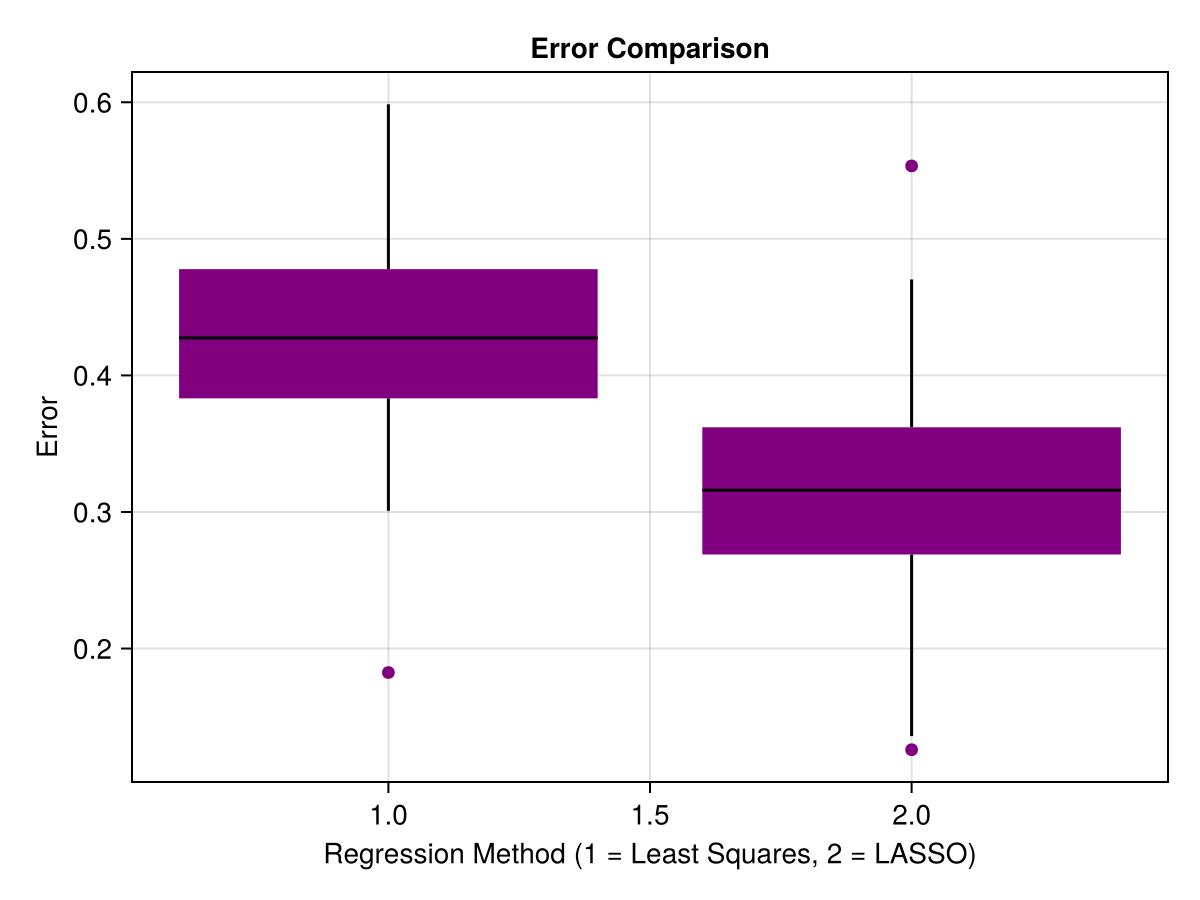

CairoMakie.Screen{IMAGE}


In [22]:
# function to run the experiment
function main()
    # set parameters
    max_degree = 19
    n_trials = 100
    noise_level = 0.1
    lambda_1 = 0.1
    lambda_2 = 0.01

    # design matrix
    A_matrix = create_design_matrix(x_vals, max_degree)

    # run trials to collect coefficients and errors
    coefficients_ls, coefficients_lasso, errors_ls, errors_lasso = run_trials(A_matrix, y_true, n_trials, noise_level, lambda_1, lambda_2)

    # plot results
    plot_results(coefficients_ls, coefficients_lasso, errors_ls, errors_lasso)
end

# rrun the main experiment
main()
